In [1]:
import argparse
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
import sys
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import os
# import seaborn as sns
%matplotlib inline

# Set font properties
plt.rcParams.update({
    'font.size': 16,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

In [2]:
res = pd.read_parquet('../../tidy_data/all_outcomes/bootstrap/full_bs_results.parquet')

In [3]:
data_dict = pd.read_csv('../../../proj_idp/Data_Dictionary_Showcase.csv',usecols=list(range(17)))
res = res.merge(data_dict.loc[:, ['FieldID', 'Path', 'Field']], left_on='outcome', right_on='FieldID', how='left')

In [4]:
res['cases'] = res.TP + res.FN

nfeat_5 = res[res['n_features'] == 5]
nfeat_50 = res[res['n_features'] == 50]
nfeat_100 = res[res['n_features'] == 100]
nfeat_500 = res[res['n_features'] == 500]
nfeat_1000 = res[res['n_features'] == 1000]
nfeat_all = res[res['n_features'] == 2923]


In [5]:
def mean_outcome(df, summ_stat='mean'):    
    # Select only numeric columns for aggregation
    numeric_cols = df.select_dtypes(include='number').columns

    # Separate string columns
    string_cols = df.select_dtypes(include='object').columns

    # Perform aggregation on numeric columns
    agg_result = df.groupby(['outcome', 'bootstrap'])[numeric_cols].agg([summ_stat, 'std']).reset_index()

    # Merge the original string columns (e.g., taking the first value for each group)
    string_result = df.groupby('outcome')[string_cols].first().reset_index()

    # Flatten the multi-level column index in agg_result
    agg_result.columns = ['_'.join(col).strip() for col in agg_result.columns.values]

    # Perform the merge after flattening the column index
    result = pd.merge(agg_result, string_result, left_on='outcome_', right_on='outcome')

    return result

summ_stat = 'mean'

mean_nfeat_5 = mean_outcome(nfeat_5, summ_stat)
mean_nfeat_50 = mean_outcome(nfeat_50, summ_stat)
mean_nfeat_100 = mean_outcome(nfeat_100, summ_stat)
mean_nfeat_500 = mean_outcome(nfeat_500, summ_stat)
mean_nfeat_1000 = mean_outcome(nfeat_1000, summ_stat)
mean_nfeat_all = mean_outcome(nfeat_all, summ_stat)

# new_res = pd.concat([mean_nfeat_5['outcome'],mean_nfeat_5[f'cases_{summ_stat}'], mean_nfeat_5[f'auroc_{summ_stat}'], mean_nfeat_5['auroc_std'], mean_nfeat_all[f'auroc_{summ_stat}'], mean_nfeat_all['auroc_std']], axis=1)
# new_res.columns = ['outcome', 'cases', f'5_features_{summ_stat}AUC', '5_features_STDEVAUC', f'all_features_{summ_stat}AUC', 'all_features_STDEVAUC']
# new_res['auroc_diff'] = new_res[f'all_features_{summ_stat}AUC'] - new_res[f'5_features_{summ_stat}AUC']

In [163]:
mean_nfeat_5.sort_values('auroc_mean').loc[:, ['outcome_', 'auroc_mean', 'cases_mean']].iloc[-20:]

,outcome_,auroc_mean,cases_mean
58786,132264,0.909040,140.0
58715,132264,0.909050,141.0
58787,132264,0.909079,140.0
58719,132264,0.909119,141.0
58750,132264,0.909185,141.0
58280,132250,0.909189,47.0
58790,132264,0.909213,140.0
58762,132264,0.909259,140.0
58708,132264,0.909261,141.0
58757,132264,0.909342,141.0


In [164]:
mean_nfeat_5.shape

(60700, 49)

In [159]:
nfeat_5.head()

,n_features,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,avg_prec,...,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos,FieldID,Path,Field,cases
0,5,132016,0,0,7796,2663,25,12,0.536583,0.003815,...,0.996803,0.004486,0.745387,0.324324,0.852954,0.008850,132016,Health-related outcomes > First occurrences > ...,Date N10 first reported (acute tubulo-intersti...,37
1,5,132016,0,1,7791,2668,26,11,0.517674,0.003645,...,0.996674,0.004106,0.744909,0.297297,0.852594,0.008100,132016,Health-related outcomes > First occurrences > ...,Date N10 first reported (acute tubulo-intersti...,37
2,5,132016,0,2,7798,2661,26,11,0.519421,0.003668,...,0.996677,0.004117,0.745578,0.297297,0.853033,0.008121,132016,Health-related outcomes > First occurrences > ...,Date N10 first reported (acute tubulo-intersti...,37
3,5,132016,0,3,7793,2666,26,12,0.525707,0.003820,...,0.996675,0.004481,0.745100,0.315789,0.852719,0.008837,132016,Health-related outcomes > First occurrences > ...,Date N10 first reported (acute tubulo-intersti...,38
4,5,132016,0,4,7797,2662,26,12,0.525775,0.003822,...,0.996676,0.004488,0.745482,0.315789,0.852970,0.008850,132016,Health-related outcomes > First occurrences > ...,Date N10 first reported (acute tubulo-intersti...,38


(array([11., 17., 26., 17.,  8.,  7.,  6.,  3.,  4.,  1.]),
 array([0.90744249, 0.90773519, 0.9080279 , 0.90832061, 0.90861331,
        0.90890602, 0.90919873, 0.90949143, 0.90978414, 0.91007685,
        0.91036955]),
 <BarContainer object of 10 artists>)

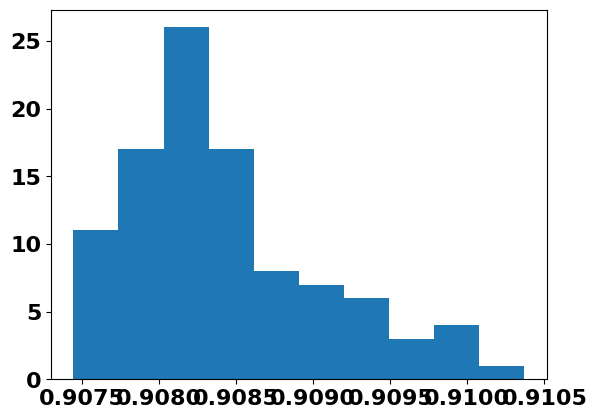

In [8]:
plt.hist(mean_nfeat_5[mean_nfeat_5.outcome == 132264]['auroc_mean'])

(array([70., 23.,  4.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.94412957, 0.94488405, 0.94563852, 0.94639299, 0.94714746,
        0.94790193, 0.94865641, 0.94941088, 0.95016535, 0.95091982,
        0.9516743 ]),
 <BarContainer object of 10 artists>)

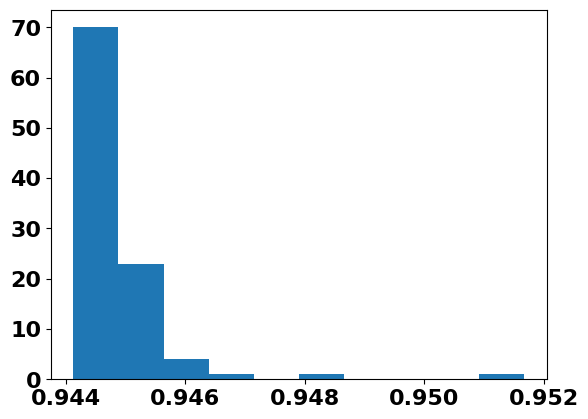

In [9]:
plt.hist(mean_nfeat_all[mean_nfeat_all.outcome == 132264]['auroc_mean'])

In [28]:
new_res

,outcome,cases,5_features_meanAUC,5_features_STDEVAUC,all_features_meanAUC,all_features_STDEVAUC,auroc_diff
0,130004,18.81,0.519551,0.054846,0.512691,0.008120,-0.006860
1,130008,200.97,0.589515,0.017279,0.659549,0.002225,0.070034
2,130014,12.87,0.548112,0.082290,0.654493,0.005841,0.106380
3,130016,136.62,0.539050,0.026279,0.566520,0.002740,0.027470
4,130018,602.91,0.584890,0.009558,0.621745,0.001187,0.036855
...,...,...,...,...,...,...,...
602,132532,27.72,0.473527,0.051829,0.481563,0.006694,0.008036
603,132536,16.83,0.529172,0.069151,0.453137,0.007963,-0.076035
604,132542,25.74,0.483884,0.047571,0.442953,0.005246,-0.040931
605,132562,19.80,0.439349,0.060710,0.436792,0.006871,-0.002557


(array([25879656.,  2927844.,   901800.,   350700.,   250500.,        0.,
           50100.,        0.,        0.,    50100.]),
 array([   9. ,  451.9,  894.8, 1337.7, 1780.6, 2223.5, 2666.4, 3109.3,
        3552.2, 3995.1, 4438. ]),
 <BarContainer object of 10 artists>)

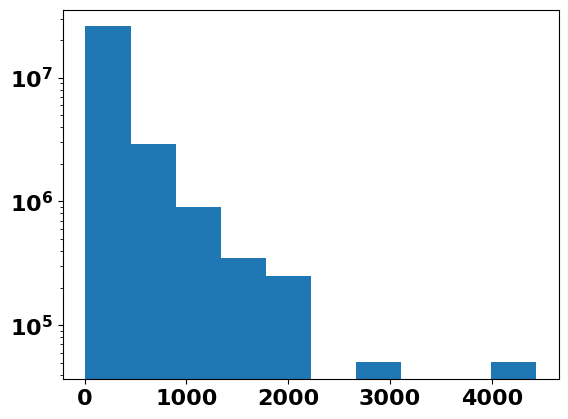

In [113]:
plt.hist(res['cases'], log=True)

In [5]:
mean_nfeat_5

outcome n_features      iteration            bootstrap             \
                  mean  std      mean        std      mean        std   
0    130004        5.0  0.0      49.5  28.867513      49.5  28.867513   
1    130008        5.0  0.0      49.5  28.867513      49.5  28.867513   
2    130014        5.0  0.0      49.5  28.867513      49.5  28.867513   
3    130016        5.0  0.0      49.5  28.867513      49.5  28.867513   
4    130018        5.0  0.0      49.5  28.867513      49.5  28.867513   
..      ...        ...  ...       ...        ...       ...        ...   
602  132532        5.0  0.0      49.5  28.867513      49.5  28.867513   
603  132536        5.0  0.0      49.5  28.867513      49.5  28.867513   
604  132542        5.0  0.0      49.5  28.867513      49.5  28.867513   
605  132562        5.0  0.0      49.5  28.867513      49.5  28.867513   
606  132574        5.0  0.0      49.5  28.867513      49.5  28.867513   

            TN                      FP  ...   rec_neg             rec_pos  \
          mean          std       mean  ...      mean       std      mean   
0    8648.0095  2579.829825  1830.1505  ...  0.825337  0.246210  0.207351   
1    9117.1650   916.398720  1178.8350  ...  0.885506  0.089005  0.195224   
2    8814.1282  2252.530365  1669.9718  ...  0.840714  0.214852  0.196685   
3    8954.4888  1962.636954  1405.8612  ...  0.864304  0.189437  0.184656   
4    7554.9222   962.185477  2339.1378  ...  0.763582  0.097249  0.354562   
..         ...          ...        ...  ...       ...       ...       ...   
602  8122.5538  3478.520915  2346.6962  ...  0.775849  0.332261  0.240281   
603  9211.8799  2289.425497  1268.2601  ...  0.878985  0.218454  0.142998   
604  8061.1315  3255.345747  2410.0985  ...  0.769836  0.310885  0.248411   
605  6682.5351  4038.389601  3794.6349  ...  0.637819  0.385447  0.362000   
606  9305.5728  1848.654048  1156.7472  ...  0.889437  0.176696  0.155571   

                 f1_neg              f1_pos             cases            
          std      mean       std      mean       std    mean       std  
0    0.273540  0.876085  0.207465  0.003379  0.003491   18.81  0.392321  
1    0.113215  0.928862  0.055723  0.057261  0.007603  200.97  0.170596  
2    0.252407  0.892078  0.182682  0.002093  0.002177   12.87  0.336320  
3    0.207856  0.907843  0.139081  0.037611  0.012643  136.62  0.485411  
4    0.106954  0.843523  0.061513  0.136589  0.006514  602.91  0.286196  
..        ...       ...       ...       ...       ...     ...       ...  
602  0.339633  0.815773  0.307497  0.004640  0.005349   27.72  0.449021  
603  0.229406  0.913295  0.189291  0.003933  0.005261   16.83  0.375652  
604  0.320911  0.819578  0.285484  0.004553  0.004235   25.74  0.438656  
605  0.382351  0.690668  0.375231  0.003179  0.002314   19.80  0.400020  
606  0.211127  0.927480  0.136592  0.009011  0.006497   34.65  0.476993  

[607 rows x 41 columns]

In [162]:
new_res.sort_values('auroc_diff').iloc[:20]

,outcome,cases,5_features_medianAUC,5_features_STDEVAUC,all_features_medianAUC,all_features_STDEVAUC,auroc_diff,Category,Path,Field
566,132188,14.0,0.702651,0.090883,0.144075,0.144075,-0.558576,NaN,NaN,NaN
583,132252,11.0,0.655086,0.109597,0.348510,0.348510,-0.306575,NaN,NaN,NaN
580,132244,21.0,0.779071,0.047553,0.492696,0.492696,-0.286375,NaN,NaN,NaN
572,132212,15.0,0.655246,0.076147,0.374496,0.374496,-0.280750,NaN,NaN,NaN
577,132238,16.0,0.761788,0.073793,0.512842,0.512842,-0.248946,NaN,NaN,NaN
89,130816,13.0,0.584310,0.082632,0.337153,0.337153,-0.247157,NaN,NaN,NaN
162,131096,14.0,0.559109,0.081974,0.315519,0.315519,-0.243589,NaN,NaN,NaN
124,130920,14.0,0.600448,0.065941,0.361708,0.361708,-0.238740,NaN,NaN,NaN
12,130104,11.0,0.514682,0.094661,0.305065,0.305065,-0.209617,NaN,NaN,NaN
537,132108,11.0,0.543851,0.084534,0.342394,0.342394,-0.201457,NaN,NaN,NaN


In [2]:
df = pd.read_parquet(f'../../tidy_data/all_outcomes/proteomics_first_occurrences.parquet')

In [3]:
df.shape

(53014, 3536)

In [4]:
prot = df.iloc[:, 1:2924]

In [95]:
pmeans = np.mean(prot, axis=0)
pstds = np.std(prot, axis=0)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 3.000e+00,
        2.900e+01, 2.008e+03, 8.260e+02, 3.500e+01, 1.000e+01, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([-2.43484495, -2.25754477, -2.0802446 , -1.90294442, -1.72564425,
        -1.54834407, -1.3710439 , -1.19374372, -1.01644355, -0.83914337,
        -0.6618432 , -0.48454302, -0.30724285, -0.12994267,  0.0473575 ,
         0.22465768,  0.40195786,  0.57925803,  0.75655821,  0.93385838,
         1.11115856]),
 <BarContainer object of 20 artists>)

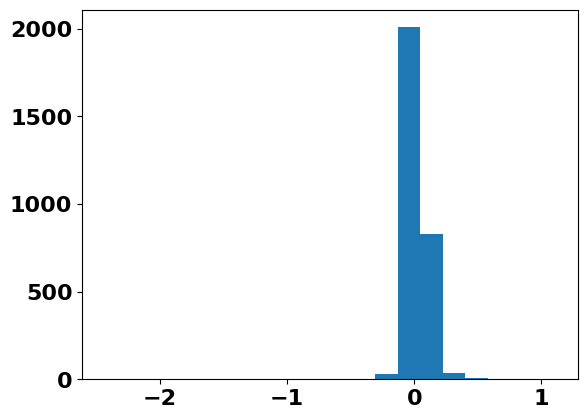

In [100]:
plt.hist(pmeans, bins=20)

In [103]:
nums = list(range(2000))

In [141]:
yes_count = 0
for j in range(100):
    l_pick = []
    for i in range(100):
        pick = np.random.choice(nums, 5, replace=False)
        l_pick.append(pick)
        
    # flatten l_pick
    l_pick = [item for sublist in l_pick for item in sublist]

    if 5 in l_pick:
        yes_count += 1

In [142]:
yes_count

17

(array([ 82., 707., 781., 557., 375., 208., 111.,  50.,  25.,  10.,   7.,
          1.,   4.,   0.,   1.,   0.,   2.,   1.,   0.,   1.]),
 array([0.08332695, 0.24395394, 0.40458093, 0.56520792, 0.7258349 ,
        0.88646189, 1.04708888, 1.20771587, 1.36834286, 1.52896985,
        1.68959684, 1.85022383, 2.01085082, 2.17147781, 2.3321048 ,
        2.49273179, 2.65335878, 2.81398577, 2.97461275, 3.13523974,
        3.29586673]),
 <BarContainer object of 20 artists>)

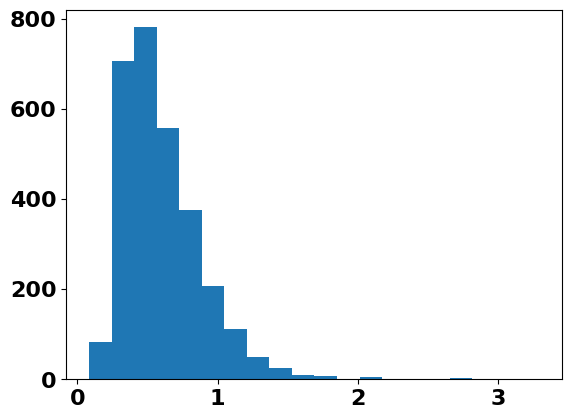

In [101]:
plt.hist(pstds, bins=20)

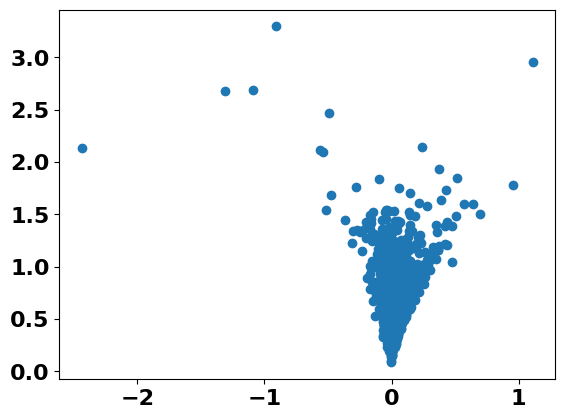

In [102]:
plt.scatter(pmeans, pstds)

In [44]:
corrp = prot.corr()

In [46]:
corrp.to_parquet('protein_correlation.parquet')

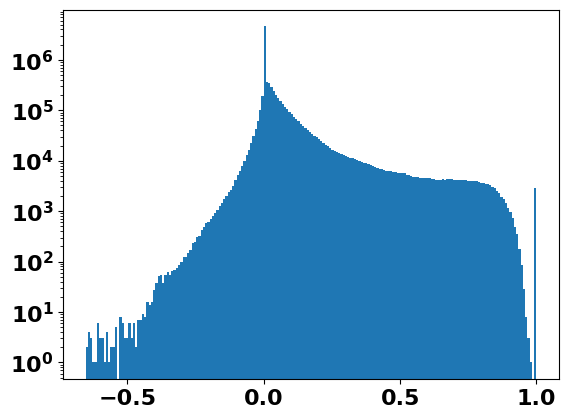

In [84]:
plt.hist(np.tril(corrp).flatten(), bins=200, log=True);

(array([  1.,   1.,   1.,   6.,   4.,  13.,  53., 206., 865., 757., 359.,
        237., 161., 116.,  67.,  43.,  22.,   4.,   3.,   3.]),
 array([-0.24773528, -0.21658752, -0.18543976, -0.154292  , -0.12314424,
        -0.09199648, -0.06084872, -0.02970096,  0.0014468 ,  0.03259457,
         0.06374233,  0.09489009,  0.12603785,  0.15718561,  0.18833337,
         0.21948113,  0.25062889,  0.28177665,  0.31292441,  0.34407217,
         0.37521993]),
 <BarContainer object of 20 artists>)

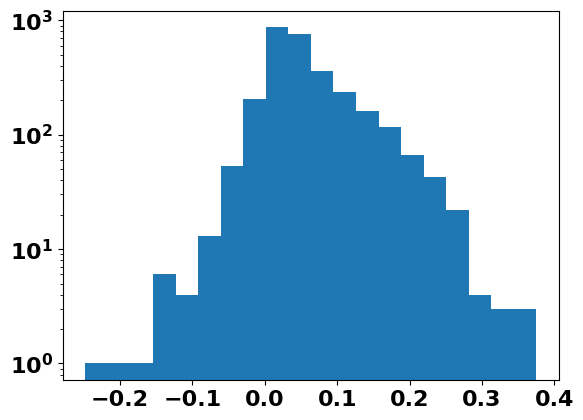

In [75]:
plt.hist(corrp['1141-0'].sort_values(ascending=False)[1:], bins=20, log=True)

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.700e+01, 3.800e+01, 3.030e+02,
        1.104e+03, 4.440e+02, 2.500e+02, 2.130e+02, 1.640e+02, 1.170e+02,
        8.200e+01, 7.000e+01, 5.300e+01, 4.000e+01, 1.200e+01, 9.000e+00,
        2.000e+00, 1.000e+00]),
 array([-2.17500978e-01, -1.81304638e-01, -1.45108298e-01, -1.08911959e-01,
        -7.27156188e-02, -3.65192790e-02, -3.22939199e-04,  3.58734006e-02,
         7.20697404e-02,  1.08266080e-01,  1.44462420e-01,  1.80658760e-01,
         2.16855099e-01,  2.53051439e-01,  2.89247779e-01,  3.25444119e-01,
         3.61640459e-01,  3.97836798e-01,  4.34033138e-01,  4.70229478e-01,
         5.06425818e-01]),
 <BarContainer object of 20 artists>)

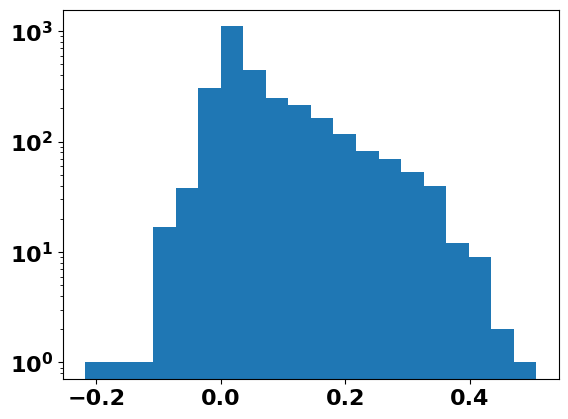

In [74]:
plt.hist(corrp['1840-0'].sort_values(ascending=False)[1:], bins=20, log=True)

In [86]:
from scipy.cluster import hierarchy

# Compute the linkage matrix
Z = hierarchy.linkage(corrp.values, method='average', metric='euclidean')

# Extract the dendrogram
dendrogram = hierarchy.dendrogram(Z, no_plot=True)

# Get the variable names and corresponding cluster numbers
variable_names = corrp.columns[dendrogram['leaves']]  # Exclude the last element
cluster_numbers = dendrogram['color_list']

# Create a dataframe with variable names and cluster numbers
df_clusters = pd.DataFrame({'Variable': variable_names, 'Cluster': cluster_numbers})

# Assign each observation to a cluster based on a threshold
threshold = 0.5  # Adjust the threshold as needed
df_clusters['Nested Cluster'] = hierarchy.fcluster(Z, threshold, criterion='distance')

# Print the dataframe with nested cluster information
print(df_clusters)


ValueError: All arrays must be of the same length

In [60]:
df_clusters[df_clusters.Variable == '1141-0']

,Variable,Cluster
1099,1141-0,C3


In [61]:
df_clusters[df_clusters.Cluster == 'C3']

,Variable,Cluster
878,257-0,C3
879,146-0,C3
880,1636-0,C3
881,367-0,C3
882,356-0,C3
...,...,...
2915,2485-0,C3
2916,1784-0,C3
2917,858-0,C3
2918,326-0,C3


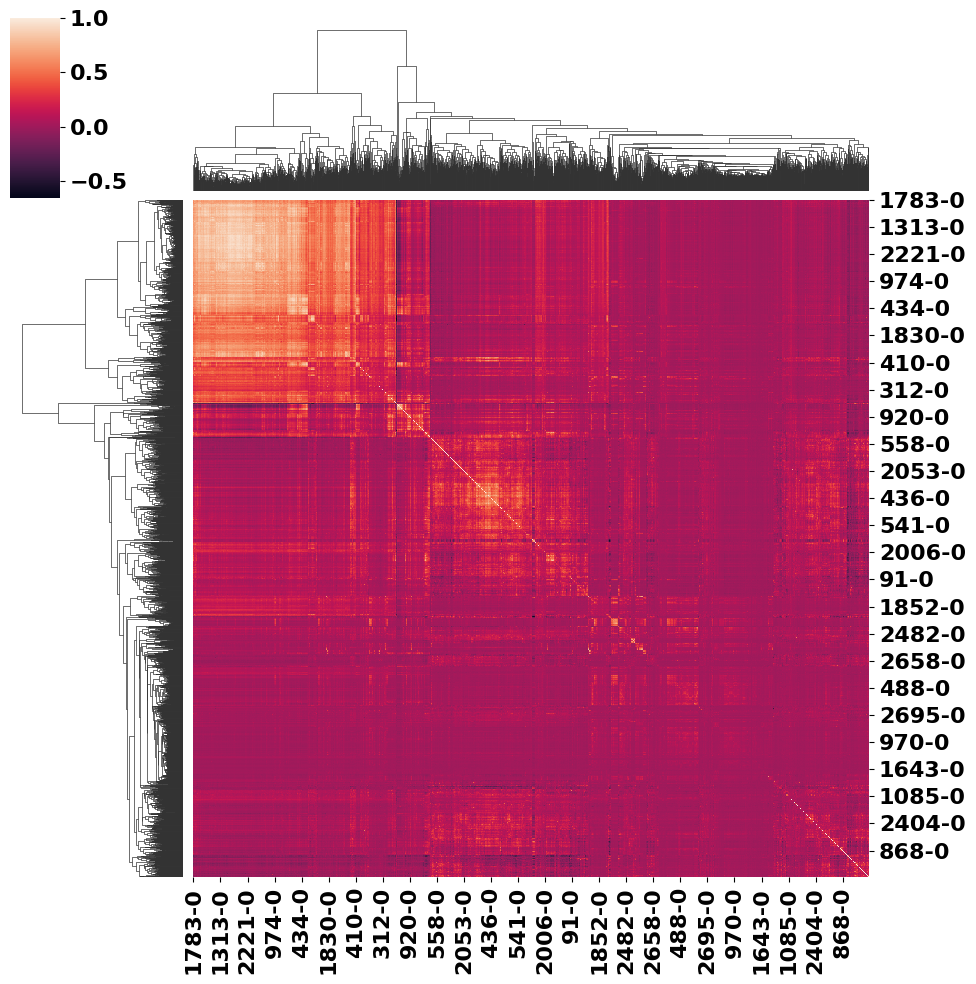

In [48]:
import seaborn as sns
sns.clustermap(corrp)

In [22]:
x=prot

# z-normalize the data -- first compute means and standard deviations
xave = np.nanmean(x,axis=0)


In [23]:
xstd = np.nanstd(x,axis=0)


In [26]:

# transpose for the sake of broadcasting (doesn't seem to work otherwise!)
ztrans = x - xave
ztrans /= xstd


In [28]:

# transpose back
z = ztrans.T

# compute correlation matrix - shape = (102000, 102000)
arr = np.matmul(z, z.T)   
arr /= z.shape[0]

In [43]:
z.T

,2738-0,2737-0,2736-0,2735-0,2734-0,2733-0,2732-0,2731-0,2739-0,2740-0,...,2357-0,2358-0,2359-0,2360-0,2361-0,732-0,134-0,37-0,1738-0,1173-0
0,0.651483,-0.089176,-0.007301,-0.982165,-0.468296,-0.545324,0.084979,0.537455,-0.397102,-0.519017,...,0.779809,0.674269,0.936195,0.709358,-1.015568,NaN,NaN,NaN,NaN,NaN
1,-0.295554,-0.215574,-0.039955,0.545632,0.430509,0.350195,1.046957,0.068920,0.179635,0.201361,...,0.529125,0.286417,1.276935,0.007153,1.200256,-0.729837,1.517566,-0.280440,-0.194085,NaN
2,-0.626911,0.518037,-0.970448,0.653937,-1.082164,0.535123,-0.205156,0.353594,-0.179549,-0.214793,...,0.256738,2.217854,0.766028,-0.205594,-0.088192,0.584749,-1.303607,-0.303168,0.602444,NaN
3,0.183578,0.340515,0.320157,-0.634194,-0.625317,-0.803475,-0.873679,-1.744641,-2.031418,-0.681606,...,0.820699,2.729420,1.113238,0.323766,-1.606397,-0.791292,-0.800230,-1.710160,-0.968475,NaN
4,-0.036719,0.405126,-0.132425,1.043323,0.599712,-0.537419,0.228095,-0.091712,-0.636761,-0.031515,...,-0.202796,-0.978455,1.504836,-0.047388,0.575145,NaN,0.606083,-1.405610,-0.706105,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53009,-0.660289,-1.600307,-0.608199,0.626185,0.551658,0.560085,0.027772,-0.330078,-0.963853,0.579320,...,-0.106234,0.393067,-1.816715,0.392142,0.031096,0.796887,-1.864988,0.661999,0.434518,NaN
53010,2.078563,1.664716,0.643037,-0.568158,1.222040,1.584159,0.386146,0.865247,1.058842,0.734748,...,1.557024,0.607079,-0.137689,0.669455,0.196028,0.828206,-0.247081,-0.081649,0.598440,NaN
53011,0.701247,0.816939,-0.104958,0.354782,-0.546130,1.754318,1.494070,0.344940,-0.052325,-0.488780,...,0.256109,0.788384,-0.579740,-1.631058,0.127863,0.371429,-0.563247,-0.056800,-0.831638,NaN
53012,0.302223,-0.195344,0.520812,0.589467,0.136942,0.101717,-0.033437,-0.502553,0.634560,NaN,...,NaN,NaN,0.558349,1.441339,NaN,1.081708,0.703113,-0.006497,1.237053,NaN


In [30]:
arr.iloc[:10, :10]

,2738-0,2737-0,2736-0,2735-0,2734-0,2733-0,2732-0,2731-0,2739-0,2740-0
2738-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2737-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2736-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2735-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2734-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2733-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2732-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2731-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2739-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2740-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import seaborn as sns
cm = sns.clustermap(prot)

In [120]:
# auroc_diffs = mean_nfeat_5[mean_nfeat_all['cases']['mean'] > 100]['auroc']['mean'] - mean_nfeat_all[mean_nfeat_all['cases']['mean'] > 100]['auroc']['mean']
auroc_diffs = mean_nfeat_1000['auroc'][summ_stat] - mean_nfeat_all['auroc'][summ_stat]
print(sum(auroc_diffs > 0))

234


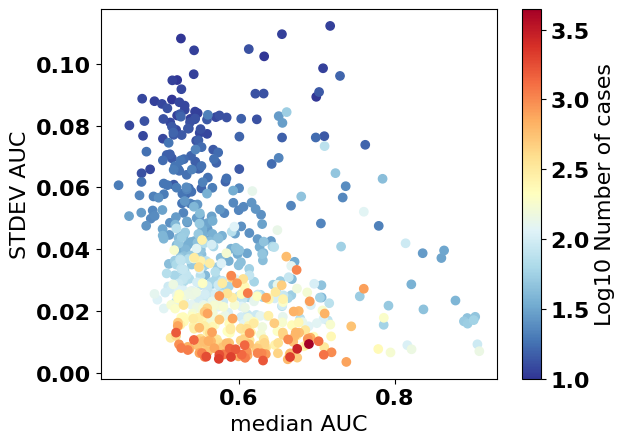

In [116]:
mean_nfeat_5 = mean_nfeat_5.sort_values(('cases', summ_stat))
plt.scatter(mean_nfeat_5['auroc'][summ_stat], mean_nfeat_5['auroc']['std'], c=np.log10(mean_nfeat_5['cases'][summ_stat]), cmap='RdYlBu_r')
plt.ylabel('STDEV AUC')
plt.xlabel(f'{summ_stat} AUC')

# colorbar
cbar = plt.colorbar()
cbar.set_label('Log10 Number of cases')

In [121]:
np.median(mean_nfeat_all['auroc'][summ_stat])

0.6157093788760615

In [122]:
abs_diffs = abs(auroc_diffs)
sum(abs_diffs < 0.05)

509

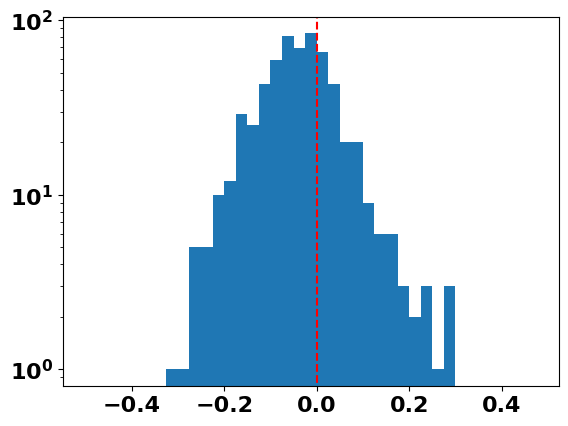

In [74]:
plt.hist(auroc_diffs, bins=np.arange(-.5, .5, 0.025), log=True);
plt.vlines(0, 0, 153, color='red', linestyle='--')

In [15]:
mean_nfeat_5['auroc_diffs'] = auroc_diffs

In [18]:
mean_nfeat_5.columns

MultiIndex([(     'outcome',     ''),
            (  'n_features', 'mean'),
            (  'n_features',  'std'),
            (   'iteration', 'mean'),
            (   'iteration',  'std'),
            (   'bootstrap', 'mean'),
            (   'bootstrap',  'std'),
            (          'TN', 'mean'),
            (          'TN',  'std'),
            (          'FP', 'mean'),
            (          'FP',  'std'),
            (          'FN', 'mean'),
            (          'FN',  'std'),
            (          'TP', 'mean'),
            (          'TP',  'std'),
            (       'auroc', 'mean'),
            (       'auroc',  'std'),
            (    'avg_prec', 'mean'),
            (    'avg_prec',  'std'),
            ( 'best_thresh', 'mean'),
            ( 'best_thresh',  'std'),
            (     'best_f1', 'mean'),
            (     'best_f1',  'std'),
            (    'accuracy', 'mean'),
            (    'accuracy',  'std'),
            ('balanced_acc', 'mean'),
            

In [23]:
mean_nfeat_5['cases']['mean']

0       18.81
1      200.97
2       12.87
3      136.62
4      602.91
        ...  
602     27.72
603     16.83
604     25.74
605     19.80
606     34.65
Name: mean, Length: 607, dtype: float64

In [125]:
mean_nfeat_5

outcome n_features      iteration            bootstrap             \
                median  std    median        std    median        std   
569  132196        5.0  0.0      49.5  28.867513      49.5  28.867513   
317  131522        5.0  0.0      49.5  28.867513      49.5  28.867513   
134  131024        5.0  0.0      49.5  28.867513      49.5  28.867513   
143  131050        5.0  0.0      49.5  28.867513      49.5  28.867513   
503  132018        5.0  0.0      49.5  28.867513      49.5  28.867513   
..      ...        ...  ...       ...        ...       ...        ...   
448  131876        5.0  0.0      49.5  28.867513      49.5  28.867513   
481  131960        5.0  0.0      49.5  28.867513      49.5  28.867513   
454  131888        5.0  0.0      49.5  28.867513      49.5  28.867513   
88   130814        5.0  0.0      49.5  28.867513      49.5  28.867513   
229  131286        5.0  0.0      49.5  28.867513      49.5  28.867513   

          TN                   FP  ...   rec_neg             rec_pos  \
      median          std  median  ...    median       std    median   
569  10159.0  1427.996243   328.0  ...  0.968723  0.136167  0.100000   
317   9093.0  2949.970397  1394.0  ...  0.867074  0.281296  0.111111   
134  10375.0   384.183162   112.0  ...  0.989320  0.036634  0.000000   
143   9524.0  2929.451706   963.5  ...  0.908129  0.279339  0.100000   
503  10331.0   745.473088   156.0  ...  0.985124  0.071085  0.000000   
..       ...          ...     ...  ...       ...       ...       ...   
448   4320.0   317.640626  4129.0  ...  0.511303  0.037592  0.741636   
481   2988.0   394.255868  5457.0  ...  0.353819  0.046681  0.778645   
454   2537.0   543.858380  5887.0  ...  0.301163  0.064561  0.799807   
88    3805.0   321.191148  3880.0  ...  0.495120  0.041793  0.766673   
229   2392.0   235.544153  3668.0  ...  0.394719  0.038870  0.846969   

                 f1_neg              f1_pos             cases            
          std    median       std    median       std  median       std  
569  0.159558  0.983732  0.134685  0.001719  0.005211    10.0  0.300015  
317  0.286102  0.928402  0.259731  0.001794  0.002685    10.0  0.300015  
134  0.128364  0.994250  0.020506  0.000000  0.008420    10.0  0.300015  
143  0.289698  0.951475  0.248280  0.001715  0.001774    10.0  0.300015  
503  0.134294  0.992078  0.043242  0.000000  0.009083    10.0  0.300015  
..        ...       ...       ...       ...       ...     ...       ...  
448  0.036296  0.650466  0.028552  0.394800  0.002646  2047.0  0.466499  
481  0.039015  0.502966  0.046686  0.350559  0.002659  2051.0  0.449021  
454  0.053307  0.446243  0.068990  0.344678  0.002306  2073.0  0.237499  
88   0.033792  0.626366  0.032021  0.485223  0.004536  2812.0  0.489922  
229  0.022808  0.524038  0.032416  0.632845  0.004348  4437.0  0.384207  

[607 rows x 41 columns]

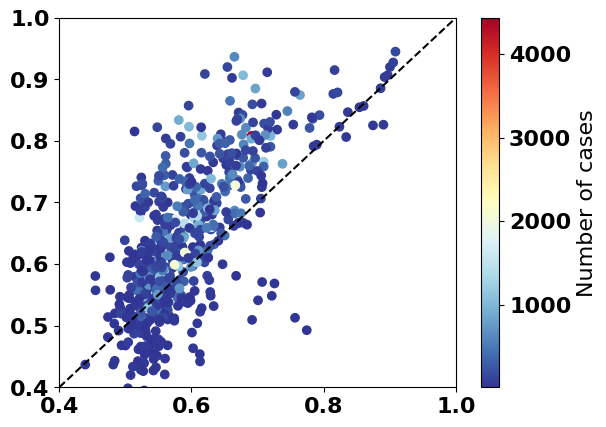

In [12]:

plt.plot([0.4, 1], [0.4, 1], 'k--')
plt.xlim([0.4, 1])
plt.ylim([0.4, 1])

# color map for values of mean_nfeat_all['cases']['mean'] with a max value of 1200
# sc = plt.scatter(mean_nfeat_5[mean_nfeat_all['cases']['mean'] > 100]['auroc']['mean'], mean_nfeat_all[mean_nfeat_all['cases']['mean'] > 100]['auroc']['mean'], label='5 features', c=mean_nfeat_all[mean_nfeat_all['cases']['mean'] > 100]['cases']['mean'], cmap='RdYlBu_r')
sc = plt.scatter(mean_nfeat_5['auroc']['mean'], mean_nfeat_all['auroc']['mean'], label='5 features', c=mean_nfeat_all['cases']['mean'], cmap='RdYlBu_r')

# colorbar
cbar = plt.colorbar()
cbar.set_label('Number of cases')


(array([197.,  47.,  18.,   6.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([ 100.98,  534.6 ,  968.22, 1401.84, 1835.46, 2269.08, 2702.7 ,
        3136.32, 3569.94, 4003.56, 4437.18]),
 <BarContainer object of 10 artists>)

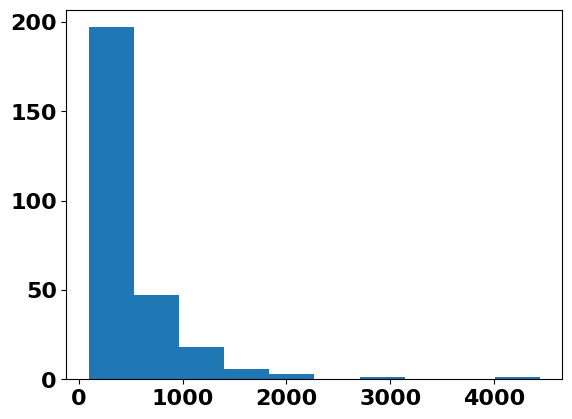

In [132]:
plt.hist(mean_nfeat_all[mean_nfeat_all['cases']['mean'] > 100]['cases']['mean'])

(array([ 13., 128., 190., 119.,  76.,  48.,  10.,   8.,   7.,   8.]),
 array([0.43934928, 0.48625844, 0.53316761, 0.58007678, 0.62698595,
        0.67389512, 0.72080429, 0.76771346, 0.81462263, 0.8615318 ,
        0.90844096]),
 <BarContainer object of 10 artists>)

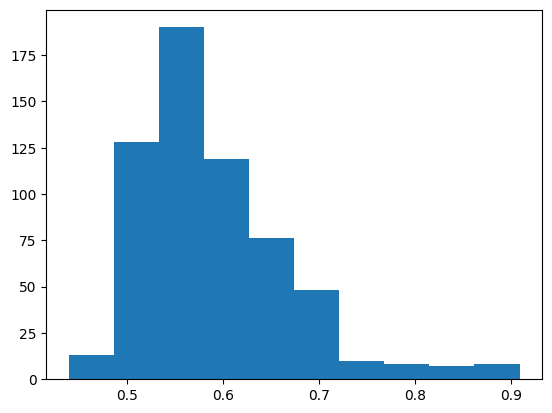

In [18]:
plt.hist(mean_nfeat_5.auroc)

In [13]:
one_outcome = res.iloc[:50100]

In [14]:
one_outcome.columns

Index(['n_features', 'outcome', 'iteration', 'bootstrap', 'TN', 'FP', 'FN',
       'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1', 'accuracy',
       'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg', 'rec_pos', 'f1_neg',
       'f1_pos'],
      dtype='object')

In [17]:
one_outcome.iteration.unique(), one_outcome.bootstrap.unique(), one_outcome.n_features.unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([   5,   50,  100,  500, 1000, 2923]))

In [19]:
proteins = pd.read_parquet('../../tidy_data/all_outcomes/bootstrap/top_proteins.parquet')

In [23]:
one_individual = pd.read_parquet('../../tidy_data/all_outcomes/bootstrap/individual_results/results_130004-0.0_0.parquet')

In [25]:
one_individual.head()

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,0,10478,0,18,0,0.568225,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,1,10478,0,18,0,0.548870,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
2,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,2,10478,0,18,0,0.564150,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
3,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,3,10478,0,19,0,0.553855,...,0.813268,0.064516,0.998190,0.5,0.998190,0.0,1.0,0.0,0.999094,0.0
4,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,4,10478,0,19,0,0.554149,...,0.813268,0.064516,0.998190,0.5,0.998190,0.0,1.0,0.0,0.999094,0.0


In [2]:
res = pd.read_parquet('../tidy_data/demographics/test_bootstrap_results.parquet')

In [8]:
res.head()

,bootstrap,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f3,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f3_neg,f3_pos
0,0,8203,2067,160,182,0.743183,0.075253,0.035859,0.397112,0.790143,0.665449,0.980868,0.080925,0.798734,0.532164,0.813846,0.341656
1,1,8182,2038,175,217,0.737672,0.089935,0.035859,0.397112,0.791462,0.677079,0.979059,0.096231,0.800587,0.553571,0.815452,0.375238
2,2,8237,2013,156,206,0.761007,0.087677,0.035859,0.397112,0.795609,0.686335,0.981413,0.092835,0.803610,0.569061,0.818437,0.376118
3,3,8280,1959,142,231,0.778479,0.106262,0.035859,0.397112,0.802017,0.713988,0.983139,0.105479,0.808673,0.619303,0.823283,0.416441
4,4,8189,2087,147,189,0.736333,0.076974,0.035859,0.397112,0.789484,0.679703,0.982366,0.083040,0.796905,0.562500,0.812240,0.356604


(array([   9.,   72.,  389., 1473., 2795., 3037., 1685.,  478.,   58.,
           4.]),
 array([0.70607458, 0.71631259, 0.72655061, 0.73678862, 0.74702664,
        0.75726465, 0.76750267, 0.77774068, 0.78797869, 0.79821671,
        0.80845472]),
 <BarContainer object of 10 artists>)

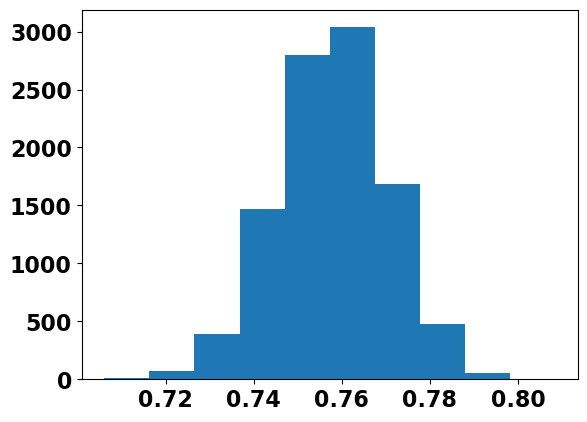

In [6]:
plt.hist(res.auroc)

In [1]:
'''
473 variables used to predict CVD in this paper:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213653
Have to get the Field IDs because they don't list them. Below is 310 variables, 163 missing, guessing they are all in S3b (types/behavior of cancer) and S3d (history of illness)
Supplementary tables
S1: 27 variables
S2: 29
S3a: 18 
S3b: 5
S3c: 14
S3d: 32
S4: 39
S5: 55
S6: 20
S7a: 7
S7b: 8
S7c: 6
S7d: 4
S7e: 5
S8a: 6
S8b: 7
S8c: 6
S9a: 9
S9b: 13


'''
s1 = [30000, 30010, 30070, 30100, 30110, 30160, 30180, 30210, 30230, 30030, 30020, 30040, 30090, 30080, 30130, 30190, 30220, 30250, 30060, 30120, 30290, 30140, 30150, 
            30170, 30200, 30240, 30260]

s2 = 

310

In [167]:
prot = pd.read_parquet('../../tidy_data/all_outcomes/proteomics_first_occurrences.parquet') 

In [169]:
prot.columns[-10:]

Index(['132532-0.0', '132536-0.0', '132542-0.0', '132562-0.0', '132574-0.0',
       '31-0.0', '53-0.0', '54-0.0', '21003-0.0', '21003-0.0_squared'],
      dtype='object')

In [9]:

prot.columns[2924:3531]

Index(['130004-0.0', '130008-0.0', '130014-0.0', '130016-0.0', '130018-0.0',
       '130020-0.0', '130022-0.0', '130062-0.0', '130064-0.0', '130068-0.0',
       ...
       '132480-0.0', '132500-0.0', '132510-0.0', '132522-0.0', '132530-0.0',
       '132532-0.0', '132536-0.0', '132542-0.0', '132562-0.0', '132574-0.0'],
      dtype='object', length=607)

In [20]:
# take the sum of non-NA values in columns 2924:3531
cases = prot.iloc[:,2924:3531].notna().sum(axis=0)


In [28]:
min(cases)

50

(array([250.,  79.,  61.,  33.,  22.,  21.,  15.,  13.,  10.,  13.,  11.,
          6.,   8.,   7.,   5.,   4.,   4.,   6.,   3.,   4.,   2.,   1.,
          4.,   2.,   1.,   4.,   2.,   1.,   1.,   0.,   1.,   2.,   1.,
          0.,   0.,   2.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   50.  ,   273.59,   497.18,   720.77,   944.36,  1167.95,
         1391.54,  1615.13,  1838.72,  2062.31,  2285.9 ,  2509.49,
         2733.08,  2956.67,  3180.26,  3403.85,  3627.44,  3851.03,
         4074.62,  4298.21,  4521.8 ,  4745.39,  4968.98,  5192.57,
         5416.16,  5639.75,  5863.34,  6086.93

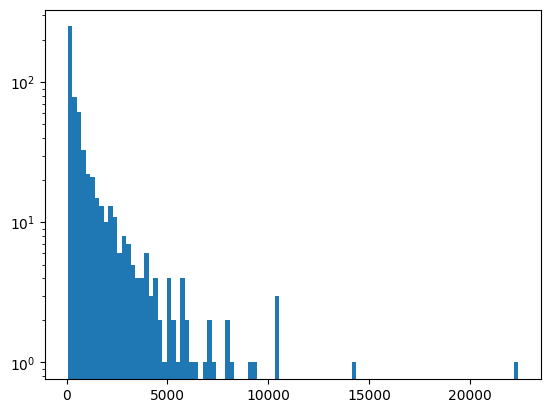

In [25]:
plt.hist(cases, log=True, bins=100)

In [37]:
len(prot.columns[2924:3531])

607

In [3]:
alleles = pd.read_csv('/n/groups/patel/randy/proj_idp/tidy_data/apoe4_snps/plink_outputs/apoee4_snps.raw', sep='\t')
alleles['apoe_polymorphism'] = np.nan
alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e3'
alleles.loc[(alleles.rs429358_C == 1) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e4'
alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 1), 'apoe_polymorphism'] = 'e2'

# Example merge
prot = prot.merge(alleles[['IID', 'apoe_polymorphism']], left_on='eid', right_on='IID')

/tmp/ipykernel_14668/2784256164.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'e3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e3'


In [4]:
acd = pd.read_parquet('../../proj_idp/tidy_data/acd/allcausedementia.parquet')
prot['label'] = prot['eid'].isin(acd.eid).astype(int)

Text(0.5, 0, 'Age')

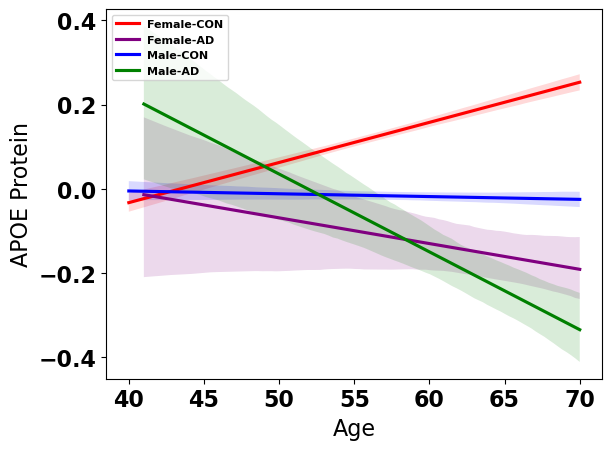

In [7]:
import seaborn as sns
protein = '154-0'
x_ci = 95
age = '21003-0.0'

sns.regplot(data=prot[ (prot['31-0.0'] == 0) & (prot.label==0) ], x=age, y=protein, scatter=False, label='Female-CON', ci=x_ci, color='red')
sns.regplot(data=prot[ (prot['31-0.0'] == 0) & (prot.label==1)], x=age, y=protein, scatter=False, label='Female-AD', ci=x_ci, color='purple')
sns.regplot(data=prot[ (prot['31-0.0'] == 1) & (prot.label==0) ], x=age, y=protein, scatter=False, label='Male-CON', ci=x_ci, color='blue')
sns.regplot(data=prot[ (prot['31-0.0'] == 1) & (prot.label==1)], x=age, y=protein, scatter=False, label='Male-AD', ci=x_ci, color='green')



# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 0) & (prot.label==0) ], x='21003-0.0', y=protein, scatter=False, label='e2-female-CON', ci=x_ci, color='red')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e2-female-AD', ci=x_ci, color='brown')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e2-male-CON', ci=x_ci, color='green')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e2-male-AD', ci=x_ci, color='black')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e3-female-CON', ci=x_ci, color='orange')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e3-female-AD', ci=x_ci, color='#1EAB46')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e3-male-CON', ci=x_ci, color='yellow')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e3-male-AD', ci=x_ci, color='#9196B0')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 0) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e4-female-CON', ci=x_ci, color='blue')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e4-female-AD', ci=x_ci, color='#A7369B')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e4-male-CON', ci=x_ci, color='purple')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e4-male-AD', ci=x_ci, color='#EE9898')

plt.legend(fontsize=8, loc='upper left')
plt.ylabel('APOE Protein')
plt.xlabel('Age')

In [19]:
prot.label

AttributeError: 'DataFrame' object has no attribute 'label'

In [14]:
prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0)]

,eid,2738-0,2737-0,2736-0,2735-0,2734-0,2733-0,2732-0,2731-0,2739-0,...,132542-0.0,132562-0.0,132574-0.0,31-0.0,53-0.0,54-0.0,21003-0.0,21003-0.0_squared,IID,apoe_polymorphism
3,1000701,0.07755,0.11670,0.10950,-0.4508,-0.19250,-0.34620,-0.40070,-1.1007,-1.31235,...,None,None,None,0,2008-07-02,11010,63,3969.0,1000701,e3
8,1000965,-0.21805,-0.07635,-0.00345,0.8309,-0.13185,-0.20925,0.05235,0.1722,-0.05675,...,None,None,None,0,2008-10-25,11008,48,2304.0,1000965,e3
9,1000992,-0.18705,0.20930,-0.04980,-0.0594,-0.19360,0.05570,0.12380,-0.2475,-0.85225,...,None,None,None,0,2009-07-14,11018,65,4225.0,1000992,e3
14,1001316,-0.06675,-0.03570,0.05800,-0.2980,-0.17120,0.00000,-0.11150,-0.0941,0.48935,...,None,None,2003-01-21,0,2009-11-11,11017,67,4489.0,1001316,e3
19,1001669,-0.04795,0.24195,-0.11385,-0.6326,0.02065,-0.06205,0.22725,0.4087,0.33945,...,None,None,None,0,2008-09-25,11009,61,3721.0,1001669,e3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52599,6022160,-0.11795,-0.01790,0.01060,1.2571,0.11140,0.55420,0.81080,-0.0939,-0.80705,...,None,None,None,0,2008-10-27,11012,59,3481.0,6022160,e3
52607,6023019,0.17915,-0.20460,-0.14120,0.1943,0.21100,0.11120,-0.30380,-0.1886,-0.69035,...,None,None,None,0,2009-01-15,11009,66,4356.0,6023019,e3
52611,6023224,0.53475,0.25490,0.16090,0.1136,0.29490,0.77510,1.00900,1.0184,0.38585,...,None,None,None,0,2009-07-06,11017,67,4489.0,6023224,e3
52623,6024239,-0.14515,-0.09850,0.44320,0.7167,-0.31370,0.01300,0.26305,-0.4723,-0.42425,...,None,None,None,0,2008-04-09,11003,40,1600.0,6024239,e3


In [2]:
def anno_protein_set(proteins):
    prot_annot = pd.read_csv('../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')
    prot_annot[['protein_id', 'meaning']] = prot_annot['meaning'].str.split(';', expand=True)
    prot_id = []
    for p in proteins:
        hyphen_idx = p.index('-')
        prot_id.append(int(p[:hyphen_idx]))
    sub_anno = prot_annot[prot_annot.coding.isin(prot_id)]
    return sub_anno

def pull_proteins(path, outcome, nf, iteration):
    
    for f in os.listdir(path):
        if outcome in f:
            res_file = f
            break
    
    df = pd.read_parquet(f'{path}/{f}')
    sub = df[(df.outcome == f'{outcome}-0.0') & (df.n_features == nf) & (df.iteration == iteration)].iloc[0]
    prot_df = anno_protein_set(sub.proteins.tolist())
    return prot_df
    
df = pd.read_parquet('../tidy_data/bootstrap/full_bs_results.parquet')

NameError: name 'pd' is not defined

In [17]:
top_rows = df.groupby(['n_features', 'outcome']).first().reset_index()
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)
top_rows = top_rows[top_rows.n_features != 2923]


In [31]:
outcome_top_rows = top_rows.groupby(['outcome']).first()
outcome_top_rows = outcome_top_rows.sort_values(by=['best_f1'], ascending=False)
outcome_top_rows

,n_features,iteration,bootstrap,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
outcome,,,,,,,,,,,,,,,,,,,
131286,1000,42,9,4078,1981,1005,3433,0.802824,0.760981,0.439742,0.697047,0.715538,0.723298,0.802282,0.634097,0.673048,0.773547,0.732005,0.696914
130714,1000,2,83,9739,158,269,331,0.922135,0.599675,0.790388,0.609174,0.959322,0.767851,0.973122,0.676892,0.984036,0.551667,0.978548,0.607897
130814,1000,42,19,6225,1461,1020,1791,0.802629,0.624908,0.525208,0.591029,0.763647,0.723527,0.859213,0.550738,0.809914,0.637140,0.833836,0.590797
130708,1000,2,90,9016,435,428,618,0.897014,0.620651,0.701411,0.589524,0.917786,0.772398,0.954680,0.586895,0.953973,0.590822,0.954327,0.588852
132032,500,82,6,9332,357,398,410,0.872010,0.500802,0.745440,0.521574,0.928075,0.735290,0.959096,0.534550,0.963154,0.507426,0.961121,0.520635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131158,1000,12,96,10397,37,61,2,0.503765,0.009520,0.651368,0.058252,0.990664,0.514100,0.994167,0.051282,0.996454,0.031746,0.995309,0.039216
131746,50,19,95,10396,64,35,2,0.567788,0.008971,0.629286,0.057692,0.990569,0.523968,0.996645,0.030303,0.993881,0.054054,0.995261,0.038835
131580,1000,7,45,10360,38,96,3,0.508729,0.014047,0.621887,0.056738,0.987234,0.513324,0.990819,0.073171,0.996345,0.030303,0.993574,0.042857


In [39]:
df_l = []

for i in range(100):
    print(i)
    dfdf = pull_proteins('../tidy_data/bootstrap/individual_results/', str(outcome_top_rows.index.values[i]), top_rows.n_features.values[i], top_rows.iteration.values[i])
    dfdf['outcome'] = top_rows.outcome.values[i]
    dfdf['n_features'] = top_rows.n_features.values[i]
    dfdf['iteration'] = top_rows.iteration.values[i]
    df_l.append(dfdf)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [40]:
alldf = pd.concat(df_l)

In [41]:
from collections import Counter
Counter(alldf.protein_id).most_common()

[('SERPINB6', 30),
 ('CDK5RAP3', 28),
 ('NIT2', 28),
 ('ADGRE1', 27),
 ('MCAM', 27),
 ('VCAM1', 27),
 ('VSIG2', 27),
 ('CD5', 27),
 ('AMIGO2', 26),
 ('CA14', 26),
 ('DPP4', 26),
 ('PCDH7', 26),
 ('PLPBP', 26),
 ('PMVK', 26),
 ('REN', 26),
 ('GP1BB', 26),
 ('RNF5', 26),
 ('PDP1', 26),
 ('ACOX1', 25),
 ('DCC', 25),
 ('EBAG9', 25),
 ('IL1RN', 25),
 ('INSL3', 25),
 ('RIPK4', 25),
 ('TPMT', 25),
 ('ZNF830', 25),
 ('CCL26', 25),
 ('MRC1', 25),
 ('PPM1F', 25),
 ('CCL17', 25),
 ('AXL', 24),
 ('BCL2L1', 24),
 ('CAPN3', 24),
 ('EDEM2', 24),
 ('HBEGF', 24),
 ('KAZN', 24),
 ('LEO1', 24),
 ('LSM8', 24),
 ('PDRG1', 24),
 ('PPP2R5A', 24),
 ('SLITRK6', 24),
 ('UHRF2', 24),
 ('VAMP8', 24),
 ('ZNF174', 24),
 ('COQ7', 24),
 ('RNASE6', 24),
 ('IL24', 24),
 ('KIR2DL2', 24),
 ('TBC1D5', 24),
 ('TF', 24),
 ('LRP11', 24),
 ('ADAMTSL2', 23),
 ('AP1G2', 23),
 ('CHRDL1', 23),
 ('CXCL11', 23),
 ('ECHDC3', 23),
 ('ERBB2', 23),
 ('ICAM3', 23),
 ('IPCEF1', 23),
 ('KLK14', 23),
 ('MEGF9', 23),
 ('MITD1', 23),
 ('NCAM

In [54]:
top_rows = df.groupby(['n_features', 'outcome', 'iteration']).first().reset_index()
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)

In [55]:
start = 0
end = start + 50
top_rows.head()

,n_features,outcome,iteration,proteins,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
405,1000,130004-0.0,5,"[2767-0, 1917-0, 1888-0, 1908-0, 1432-0, 1179-...",90,10477,2,17,1,0.568420,...,0.692236,0.181818,0.998190,0.527682,0.998380,0.333333,0.999809,0.055556,0.999094,0.095238
431,1000,130004-0.0,31,"[2321-0, 498-0, 2215-0, 404-0, 66-0, 1239-0, 1...",95,10479,0,18,0,0.523269,...,0.686319,0.105263,0.998285,0.500000,0.998285,0.000000,1.000000,0.000000,0.999142,0.000000
350,500,130004-0.0,50,"[914-0, 1722-0, 2537-0, 829-0, 1687-0, 1931-0,...",97,10424,55,15,3,0.618205,...,0.613036,0.103896,0.993331,0.580709,0.998563,0.051724,0.994751,0.166667,0.996654,0.078947
118,50,130004-0.0,18,"[1617-0, 2477-0, 156-0, 2837-0, 2691-0, 973-0,...",88,10478,1,18,0,0.577197,...,0.796994,0.100000,0.998190,0.499952,0.998285,0.000000,0.999905,0.000000,0.999094,0.000000
181,50,130004-0.0,81,"[1587-0, 1242-0, 2814-0, 1691-0, 1883-0, 781-0...",1,10476,2,18,0,0.553345,...,0.774643,0.095238,0.998095,0.499905,0.998285,0.000000,0.999809,0.000000,0.999046,0.000000


In [59]:
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)
tr_df = top_rows[top_rows.n_features < 2923]
# ppp = pull_proteins('../tidy_data/bootstrap/individual_results/', str(tr_df.outcome[0]), tr_df.n_features[0], tr_df.iteration[0], )

In [65]:
df.shape

(50100, 21)

In [ ]:
results

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,0,5236,56,9,0,0.620685,...,0.666112,0.029851,0.987738,0.494709,0.998284,0.000000,0.989418,0.000000,0.993831,0.000000
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,1,5292,0,10,0,0.492933,...,0.813268,0.117647,0.998114,0.500000,0.998114,0.000000,1.000000,0.000000,0.999056,0.000000
2,5,"[948-0, 250-0, 2648-0, 1608-0, 2875-0]",130004-0.0,1,0,4347,945,6,3,0.624801,...,0.402726,0.008351,0.820600,0.577381,0.998622,0.003165,0.821429,0.333333,0.901400,0.006270
3,5,"[948-0, 250-0, 2648-0, 1608-0, 2875-0]",130004-0.0,1,1,5007,285,8,2,0.585317,...,0.528834,0.020134,0.944738,0.573073,0.998405,0.006969,0.946145,0.200000,0.971573,0.013468


In [35]:
path = '../tidy_data/bootstrap/individual_results/'
outcome = str(top_rows.outcome[0])
nf = 5
iteration = 99
for f in os.listdir(path):
    if outcome in f:
        res_file = f
        break

df = pd.read_parquet(f'{path}/{f}')
sub = df[(df.outcome == f'{outcome}-0.0') & (df.n_features == nf) & (df.iteration == iteration)].iloc[0]
prot_df = anno_protein_set(sub.proteins.tolist())

In [7]:
df

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,0,9983,367,112,34,0.813986,...,0.783636,0.127737,0.954364,0.598709,0.988905,0.084788,0.964541,0.232877,0.976571,0.124314
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,1,9989,361,112,34,0.811065,...,0.783636,0.129151,0.954935,0.598999,0.988912,0.086076,0.965121,0.232877,0.976872,0.125693
2,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,2,9985,365,112,34,0.808816,...,0.783636,0.128205,0.954554,0.598806,0.988908,0.085213,0.964734,0.232877,0.976671,0.124771
3,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,3,9986,364,113,34,0.809239,...,0.783636,0.128205,0.954558,0.598062,0.988811,0.085427,0.964831,0.231293,0.976674,0.124771
4,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,4,9983,367,113,34,0.808381,...,0.783636,0.127505,0.954273,0.597917,0.988807,0.084788,0.964541,0.231293,0.976524,0.124088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,95,10046,305,96,50,0.879855,...,0.660134,0.203187,0.961799,0.656500,0.990534,0.140845,0.970534,0.342466,0.980432,0.199601
50096,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,96,10044,307,96,50,0.881313,...,0.660134,0.202381,0.961608,0.656403,0.990533,0.140056,0.970341,0.342466,0.980333,0.198807
50097,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,97,10044,307,96,50,0.879741,...,0.660134,0.202381,0.961608,0.656403,0.990533,0.140056,0.970341,0.342466,0.980333,0.198807
50098,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,98,10042,309,97,49,0.880176,...,0.660134,0.198020,0.961322,0.652882,0.990433,0.136872,0.970148,0.335616,0.980185,0.194444


In [6]:
df = pd.read_parquet('../tidy_data/bootstrap/individual_results/results_131036-0.0_138.parquet')
# df = df.loc[:,['n_features', 'outcome', 'proteins', 'iteration']]
# df = df.groupby(['n_features', 'outcome', 'iteration']).first().reset_index()
# df = df.drop(columns=['outcome'])

# prot_annot = pd.read_csv('../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')

In [10]:
group_median = df.groupby(['n_features'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos']].median()

In [11]:
group_median

,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
n_features,,,,,,,,,,,,,,,,
5,9963.0,387.0,111.0,36.0,0.821084,0.060208,0.787085,0.122951,0.952463,0.601744,0.988970,0.078947,0.962609,0.244898,0.975569,0.116869
50,9865.0,485.0,105.0,42.0,0.819438,0.059040,0.756802,0.122722,0.943698,0.619065,0.989484,0.077540,0.953140,0.285714,0.970914,0.118012
100,9819.0,531.0,101.0,46.0,0.822470,0.061320,0.735161,0.125245,0.939697,0.631015,0.989876,0.077572,0.948696,0.312925,0.968776,0.121673
500,10043.0,307.0,108.0,39.0,0.837111,0.075831,0.736123,0.148148,0.960084,0.616136,0.989338,0.104332,0.970338,0.265306,0.979580,0.143284
1000,10053.0,297.0,105.0,41.0,0.854619,0.094501,0.721989,0.177972,0.961894,0.626743,0.989644,0.127660,0.971304,0.280822,0.980482,0.173375
2923,10043.0,307.0,97.0,50.0,0.878252,0.105460,0.660134,0.201581,0.961513,0.655189,0.990434,0.139470,0.970338,0.340136,0.980283,0.198020


In [12]:
df = pd.read_parquet('../tidy_data/bootstrap/full_bs_results.parquet')

df['n_cases'] = df.FN + df.TP
df['n_controls'] = df.FP + df.TN
df['percent_cases'] = 100 * (df['n_cases'] / (df['n_cases'] + df['n_controls']))

In [19]:
group_median = df.groupby(['n_features', 'outcome'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos', 'n_cases', 'n_controls', 'percent_cases']].median()

[None]

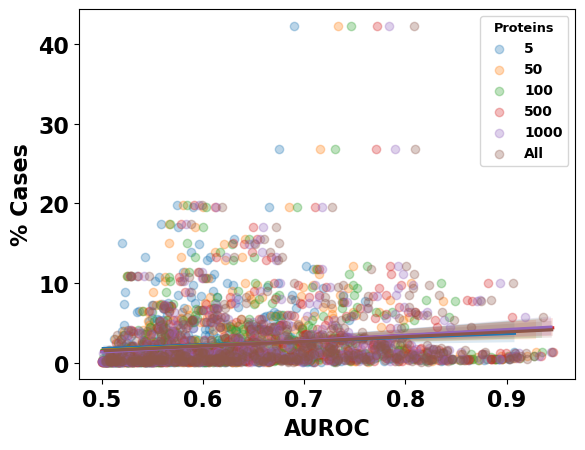

In [5]:
pdf = group_median[group_median.auroc >= 0.5]

label_dict = {'auroc': 'AUROC', 'prec_pos': 'Precision', 'avg_prec': "Average Precision", 'f1_pos': 'F1 Positive', 'percent_cases': '% Cases'}
x_col = 'auroc'
y_col = 'percent_cases'
sk = {'alpha': 0.3}
sns.regplot(data=pdf.loc[(5)], x=x_col, y=y_col, scatter_kws=sk, label='5' )
sns.regplot(data=pdf.loc[(50)], x=x_col, y=y_col, scatter_kws=sk, label='50')
sns.regplot(data=pdf.loc[(100)], x=x_col, y=y_col, scatter_kws=sk, label='100')
sns.regplot(data=pdf.loc[(500)], x=x_col, y=y_col, scatter_kws=sk, label='500')
sns.regplot(data=pdf.loc[(1000)], x=x_col, y=y_col, scatter_kws=sk, label='1000')
sns.regplot(data=pdf.loc[(2923)], x=x_col, y=y_col, scatter_kws=sk, label='All')
legend = plt.legend(title="Proteins", fontsize=10)
plt.ylabel(label_dict[y_col], fontweight='bold')
plt.xlabel(label_dict[x_col], fontweight='bold')
plt.setp(legend.get_title(),fontsize='xx-small')


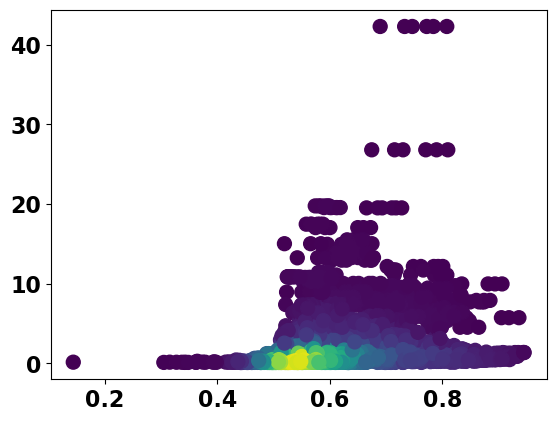

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plot_df

x = group_median.auroc
y = group_median.percent_cases

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

In [10]:
sum(group_median.percent_cases==0)

0

(array([1.000e+00, 0.000e+00, 1.300e+01, 5.300e+01, 8.960e+02, 1.254e+03,
        7.210e+02, 4.080e+02, 2.170e+02, 7.900e+01]),
 array([0.1440751 , 0.22423687, 0.30439864, 0.38456041, 0.46472218,
        0.54488395, 0.62504572, 0.70520749, 0.78536926, 0.86553103,
        0.9456928 ]),
 <BarContainer object of 10 artists>)

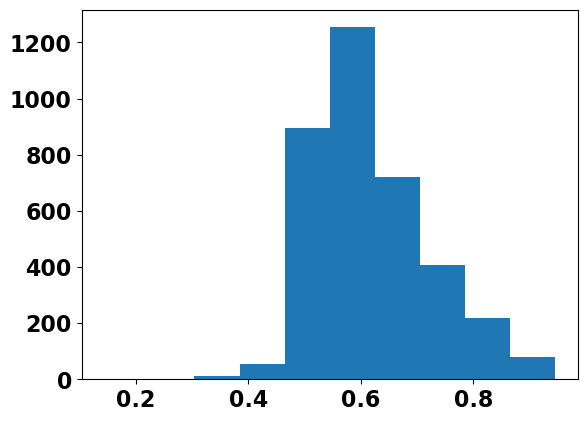

In [6]:
plt.hist(group_median.auroc)

In [72]:
group_median[group_median.percent_cases > 20]

TN      FP      FN      TP     auroc  avg_prec  \
n_features outcome                                                       
5          130814   3805.0  3880.0   656.0  2155.5  0.674663  0.398674   
           131286   2392.0  3668.0   679.0  3758.0  0.689695  0.597718   
50         130814   4455.0  3230.0   755.5  2056.0  0.715297  0.459271   
           131286   2983.0  3077.0   781.0  3656.0  0.733175  0.659775   
100        130814   4738.0  2947.0   786.0  2025.0  0.730289  0.484145   
           131286   3148.0  2912.0   812.0  3625.0  0.746779  0.679065   
500        130814   5608.0  2077.5   941.0  1870.0  0.770742  0.566516   
           131286   3555.0  2505.0   883.0  3554.0  0.772373  0.718169   
1000       130814   5958.0  1728.0   991.0  1821.0  0.789865  0.602085   
           131286   3655.0  2405.0   890.0  3547.0  0.784209  0.735775   
2923       130814   6322.0  1363.0  1017.0  1795.0  0.809879  0.633928   
           131286   3783.0  2277.0   828.0  3609.0  0.808099  0.767748   

                    best_thresh   best_f1  accuracy  balanced_acc  prec_neg  \
n_features outcome                                                            
5          130814      0.462181  0.485386  0.567591      0.628440  0.852512   
           131286      0.383841  0.632957  0.586453      0.621277  0.778686   
50         130814      0.466189  0.509443  0.621225      0.656974  0.856774   
           131286      0.393675  0.653353  0.629608      0.656182  0.791549   
100        130814      0.471905  0.521029  0.645899      0.668589  0.857934   
           131286      0.400864  0.660244  0.645613      0.668095  0.794737   
500        130814      0.500154  0.555106  0.711727      0.698631  0.857186   
           131286      0.408941  0.674832  0.674478      0.690985  0.800364   
1000       130814      0.512957  0.573377  0.741640      0.711845  0.857185   
           131286      0.410694  0.682281  0.687339      0.701998  0.803994   
2923       130814      0.531349  0.601558  0.773269      0.730480  0.861425   
           131286      0.397105  0.699500  0.704392      0.719022  0.820321   

                    prec_pos   rec_neg   rec_pos    f1_neg    f1_pos  n_cases  \
n_features outcome                                                              
5          130814   0.356432  0.495120  0.766673  0.626366  0.485223   2812.0   
           131286   0.506545  0.394719  0.846969  0.524038  0.632845   4437.0   
50         130814   0.390558  0.579701  0.731282  0.690989  0.509258   2812.0   
           131286   0.540921  0.492244  0.823980  0.605949  0.653231   4437.0   
100        130814   0.408903  0.616526  0.720384  0.718290  0.520843   2812.0   
           131286   0.555013  0.519472  0.816993  0.628571  0.660126   4437.0   
500        130814   0.472489  0.729686  0.665244  0.787547  0.554897   2812.0   
           131286   0.584069  0.586634  0.800992  0.675450  0.674709   4437.0   
1000       130814   0.514265  0.775176  0.647582  0.814923  0.573145   2812.0   
           131286   0.596863  0.603135  0.799414  0.690055  0.682156   4437.0   
2923       130814   0.568373  0.822642  0.638336  0.841587  0.601324   2812.0   
           131286   0.613256  0.624257  0.813387  0.709079  0.699366   4437.0   

                    n_controls  percent_cases  
n_features outcome                             
5          130814       7685.0      26.788606  
           131286       6060.0      42.269220  
50         130814       7685.0      26.788606  
           131286       6060.0      42.269220  
100        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
500        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
1000       130814       7685.0      26.788606  
           131286       6060.0      42.269220  
2923       130814       7685.0      26.788606  
           131286       6060.0      42.269220

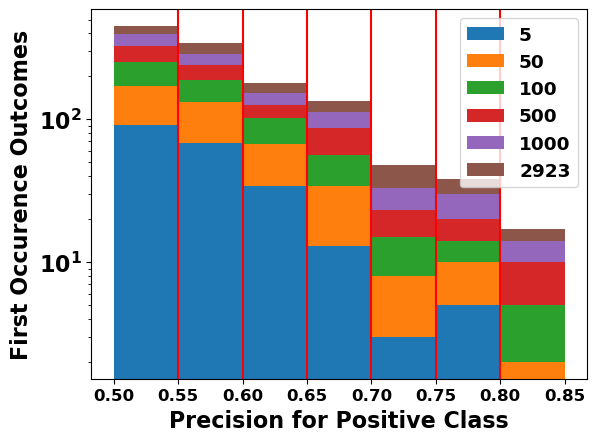

In [106]:
marker_range = np.arange(0.5,0.9,0.05)
metric = 'AUROC'
newcols = []
for nf in [5, 50, 100, 500, 1000, 2923]:
 newcols.append(dfres[dfres.n_features == nf][metric])

df_newcols = pd.concat(newcols, axis=1)
df_newcols.columns = [str(x) for x in [5, 50, 100, 500, 1000, 2923]]

plt.hist(df_newcols, bins = marker_range, 
    histtype='bar', stacked=True, label = [5, 50, 100, 500, 1000, 2923], log=True)
plt.legend(fontsize='small')
plt.ylabel("First Occurence Outcomes", weight='bold')
plt.xlabel("Precision for Positive Class", weight='bold')

# Adjust font properties for x-axis tick labels
plt.tick_params(axis='x', labelsize=12)  # Set font size for x-axis tick labels

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=900, color='red')

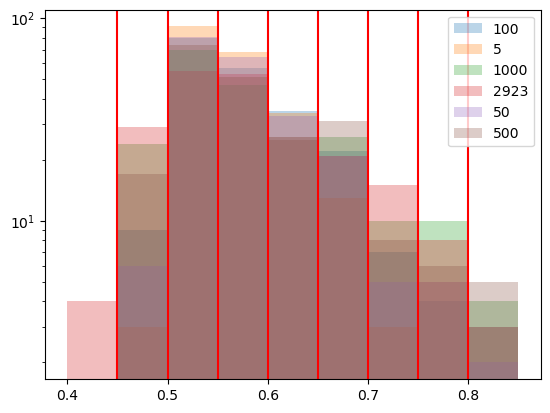

In [59]:
for nf in [5, 50, 100, 500, 1000, 2923]:
    plt.hist(dfres[dfres.n_features == nf].AUROC, bins=marker_range, log=True, alpha=0.3, label=nf)
    plt.legend()

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=500, color='red')
    # plt.vlines(0.6, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.7, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.8, ymin=0.5, ymax=500, color='k')